In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.__version__

'1.3.1'

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np

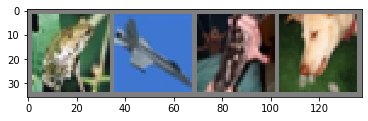

 frog plane   cat   dog


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print( ' '.join('%5s' % classes[labels[j]] for j in range(4)) )

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
print(device)

cuda:0


In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 *5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
from torch.utils.tensorboard import SummaryWriter
import shutil
import os

if os.path.exists('./runs/cifar10_experiment_1'):
    shutil.rmtree('./runs/cifar10_experiment_1')
writer = SummaryWriter('runs/cifar10_experiment_1')

In [10]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


def images_to_probs(net, images):
    output = net(images)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [11]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i+1) % 1000 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch +1,
                                           i + 1,
                                           running_loss / 2000))
            
            
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            
            running_loss = 0.0
            
print('Finised Training')

[1,  1000] loss: 1.144
[1,  2000] loss: 1.053
[1,  3000] loss: 0.958
[1,  4000] loss: 0.884
[1,  5000] loss: 0.862
[1,  6000] loss: 0.829
[1,  7000] loss: 0.791
[1,  8000] loss: 0.781
[1,  9000] loss: 0.764
[1, 10000] loss: 0.756
[1, 11000] loss: 0.723
[1, 12000] loss: 0.729
[2,  1000] loss: 0.706
[2,  2000] loss: 0.688
[2,  3000] loss: 0.686
[2,  4000] loss: 0.682
[2,  5000] loss: 0.661
[2,  6000] loss: 0.652
[2,  7000] loss: 0.665
[2,  8000] loss: 0.648
[2,  9000] loss: 0.645
[2, 10000] loss: 0.637
[2, 11000] loss: 0.622
[2, 12000] loss: 0.635
Finised Training


In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

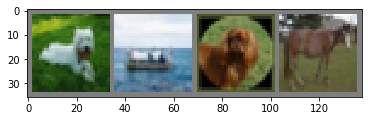

GroundTruth:    dog  ship   dog horse


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
outputs = net(images.to(device))

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:  horse  ship   dog  deer


In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 72 %
Accuracy of  bird : 46 %
Accuracy of   cat : 38 %
Accuracy of  deer : 45 %
Accuracy of   dog : 32 %
Accuracy of  frog : 74 %
Accuracy of horse : 64 %
Accuracy of  ship : 73 %
Accuracy of truck : 58 %
